<a href="https://colab.research.google.com/github/IhabBendidi/sentiment_embeddings/blob/main/lstm_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
pip install scikit-learn tensorflow==2.3 pandas numpy keras keras-metrics

In [1]:
#https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn
#https://www.analyticsvidhya.com/blog/2019/11/comprehensive-guide-attention-mechanism-deep-learning/
#https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd 
#https://www.kaggle.com/ngyptr/lstm-sentiment-analysis-keras
#https://towardsdatascience.com/twitter-sentiment-analysis-nlp-text-analytics-b7b296d71fce 
#https://github.com/pjwebdev/Basic-Data-Science-Projects/blob/master/8-Twitter-Sentiment-Analysis/Tweeter%20Sentiment%20Analysis.ipynb

import random
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
from pylab import rcParams
from keras import backend as K
import seaborn as sns

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

In [2]:
# Nettoyer le caca, les signes, la ponctuation, ajouter les autres variables, augmenter la taille des features.
# Read the csv file with panda
df = pd.read_csv('/content/Tweets.csv')

# Select the text column in order to create your features
#features_words = df['text']

# Select the airline_sentiment column as the targets
#target = df['airline_sentiment']
# Get dummies values of the three classes, meaning one 3 dimensional vector of interger values for each line
#target = pd.get_dummies(df['airline_sentiment']).values

In [4]:
print(df.head(5))

             tweet_id  ...               user_timezone
0  570306133677760513  ...  Eastern Time (US & Canada)
1  570301130888122368  ...  Pacific Time (US & Canada)
2  570301083672813571  ...  Central Time (US & Canada)
3  570301031407624196  ...  Pacific Time (US & Canada)
4  570300817074462722  ...  Pacific Time (US & Canada)

[5 rows x 15 columns]


In [5]:

# importing the interesting & pertinent data in our dataset into a new dataframe
tweets = df[['tweet_id','text','airline_sentiment','airline_sentiment_confidence']]
tweets.head()
# The count of null or nan values in the dataset
tweets.isnull().sum()
# Unique values in a Series of the dataframe
tweets['airline_sentiment'].unique()
# This helper function returns the tags appearing mostly at the beginning of each tweet
def get_tags(row):
    splits = row['text'].split(' ')
    # Some simple text processing to have all tags in the same format ???????
    row['tags'] = ''.join(e for e in splits[0] if e.isalnum()).lower()   
    # Correcting a very common typo
    if row['tags'] == 'jetblue':
        row['tags'] = 'jetblues'
    return row

# Extracting the tags (without deletion) from the tweets into their own columns
df = tweets.apply(get_tags,axis=1)

In [6]:
# Defining a helper function to count the occurences of each category of sentiment for each tag
def count_tags(df, col, new_col):
    df[new_col] = df[col].count()
    return df

# Grouping all tags and sentiment categories together, in order to count occurences of categories 
# of sentiments for each category, then saving the resulting Series into our DataFrame
df['tag_count'] = df.groupby(['tags','airline_sentiment']).apply(count_tags,'tweet_id','count')['count']

In [8]:
temp_df = df[df['tag_count']>15].copy()

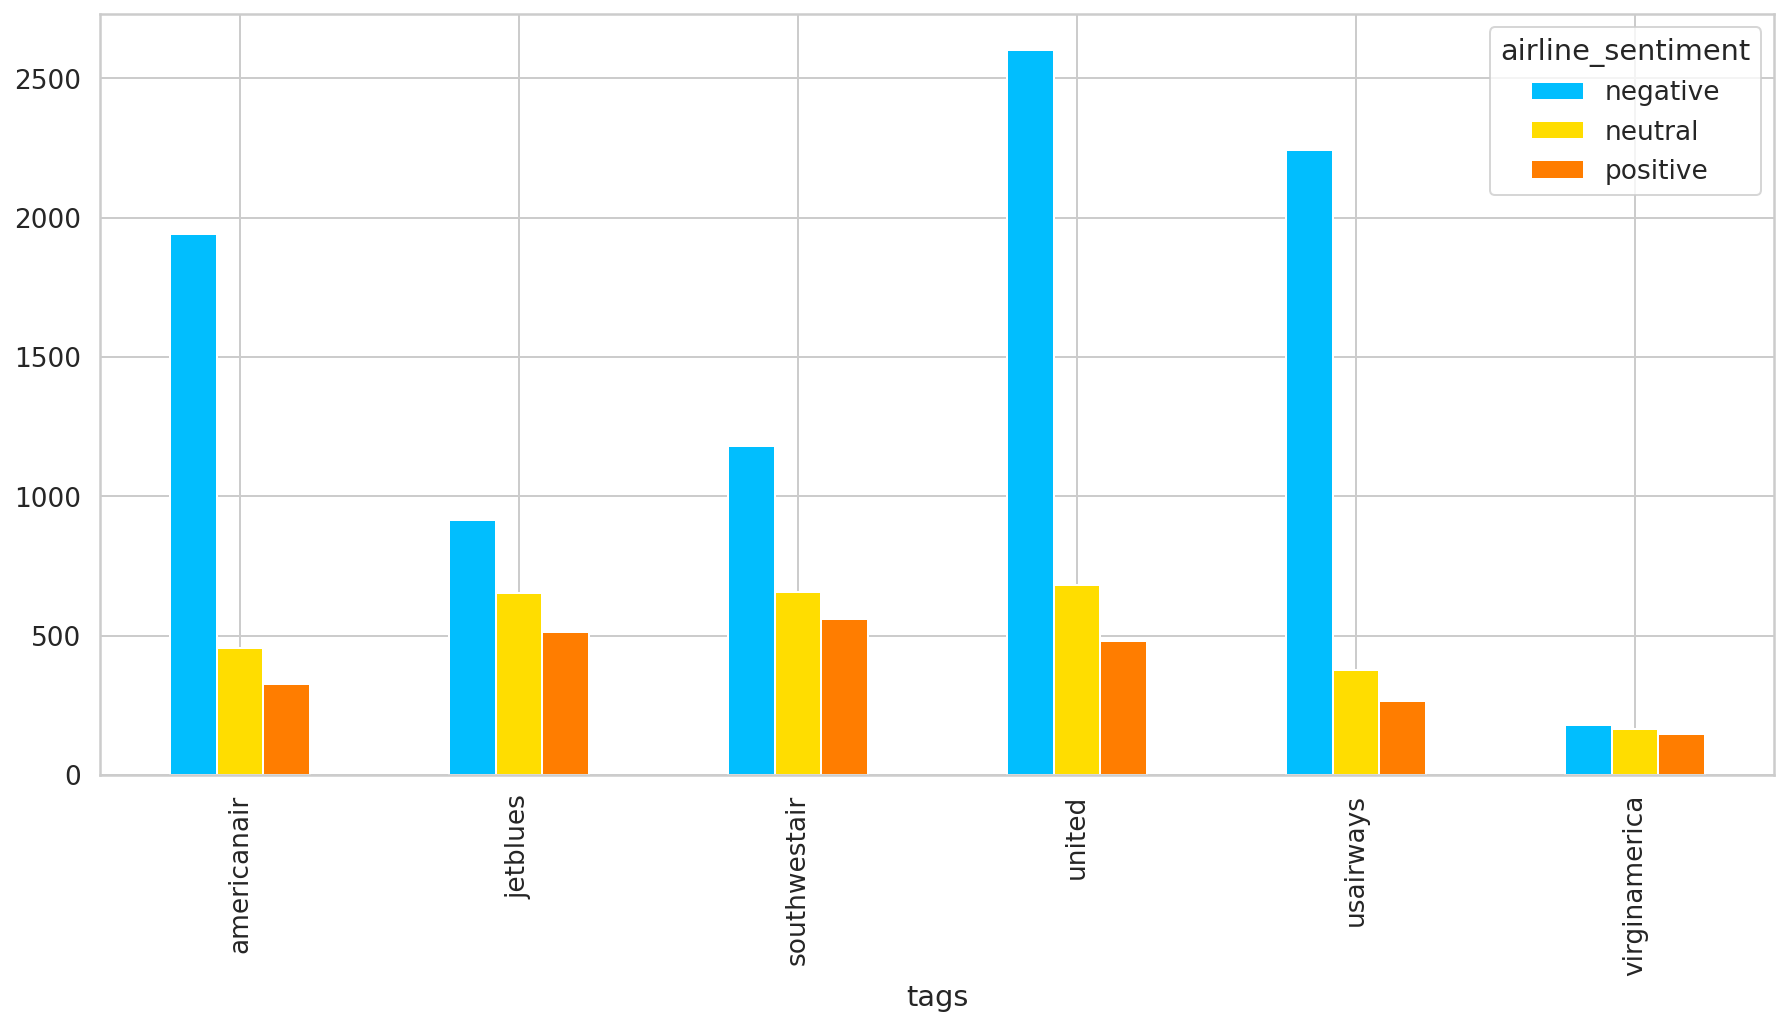

In [9]:
# Create a cross table of the count of the occurences of tags/sentiment classes
cross_df = pd.crosstab(temp_df.tags,temp_df.airline_sentiment,values=temp_df['tag_count'],
                       margins=False,aggfunc='mean')

# Visualize our results in a bar plot
cross_df.plot.bar(figsize=(15,7),grid=True)

In [13]:
pip install seaborn

In [10]:
# A helper function that would remove the tags from the text and save it into a new column
def remove_tags(row):
    splits = row['text'].split(' ')
    row['review'] = ' '.join(splits[1:])
    return row

# Removing the tags from the text and saving the cleaned up text in a new column
tweets = df.apply(remove_tags,axis=1)[['tweet_id','text','review','airline_sentiment']]

tweets.head()

,tweet_id,text,review,airline_sentiment
0,570306133677760513,@VirginAmerica What @dhepburn said.,What @dhepburn said.,neutral
1,570301130888122368,@VirginAmerica plus you've added commercials t...,plus you've added commercials to the experienc...,positive
2,570301083672813571,@VirginAmerica I didn't today... Must mean I n...,I didn't today... Must mean I need to take ano...,neutral
3,570301031407624196,@VirginAmerica it's really aggressive to blast...,"it's really aggressive to blast obnoxious ""ent...",negative
4,570300817074462722,@VirginAmerica and it's a really big bad thing...,and it's a really big bad thing about it,negative


In [11]:
# Define a helper function for one hot encoding
def one_hot_encode(row):
    if row['airline_sentiment'] == "negative":
        row['target'] = 0
    if row['airline_sentiment'] == "neutral":
        row['target'] = 1
    if row['airline_sentiment'] == "positive":
        row['target'] = 2
    return row

# The class names : 0 -> negative, 1 -> neutral, 2 -> positive
class_names = ['negative', 'neutral', 'positive']

# One hot encode the labels of our dataset
tweets = tweets.apply(one_hot_encode,axis=1)[['review','target','tweet_id','text','airline_sentiment']]

tweets.head()

,review,target,tweet_id,text,airline_sentiment
0,What @dhepburn said.,1,570306133677760513,@VirginAmerica What @dhepburn said.,neutral
1,plus you've added commercials to the experienc...,2,570301130888122368,@VirginAmerica plus you've added commercials t...,positive
2,I didn't today... Must mean I need to take ano...,1,570301083672813571,@VirginAmerica I didn't today... Must mean I n...,neutral
3,"it's really aggressive to blast obnoxious ""ent...",0,570301031407624196,@VirginAmerica it's really aggressive to blast...,negative
4,and it's a really big bad thing about it,0,570300817074462722,@VirginAmerica and it's a really big bad thing...,negative


In [13]:
features_words = tweets['review']
# Select the airline_sentiment column as the targets
#target = tweets['airline_sentiment']

# Get dummies values of the three classes, meaning one 3 dimensional vector of interger values for each line
target = pd.get_dummies(df['airline_sentiment']).values

In [15]:
print(target)

[[0 1 0]
 [0 0 1]
 [0 1 0]
 ...
 [0 1 0]
 [1 0 0]
 [0 1 0]]


In [16]:
# Max features determine the max number of words in the entire dataset you will consider relevant
max_features = 500
# Create a tokenizer object and pass the max features to it
tokenizer = Tokenizer(num_words=max_features, split=' ')
# Call the tokenizer method fit_on_texts and fit the values of your features to it
tokenizer.fit_on_texts(features_words.values)
# Convert each line of text to sequences of integer values where each value correspond to one of the 100 max features
X = tokenizer.texts_to_sequences(features_words.values)
# Pad sequences is needed to homogenize the size of each line vector (if 100 max_features, then each line vector will be converted to 25dim vectors, blank or no words
# will be filled with zero value
X = pad_sequences(X)

# Split your dataset between train and test
X_train, X_test, Y_train, Y_test = train_test_split(X,target, test_size = 0.33, random_state=42)

In [30]:
#X_train, X_test = np.expand_dims(X_train, axis=0), np.expand_dims(X_test, axis=0)

In [17]:
# Number of neurons for each of the two layers of the LSTM
embed_dim = 50
lstm_out = 70
# Use adam optimizer with
opt = Adam(learning_rate=0.00001)
#Instantiate a sequential model
model = Sequential()
# Create a first embedding layer and add it to the model in which you will pass the max_features arguments, the embed_dimension
# corresponding to the number of neurons for the first layer and the second dim of your features vector
model.add(Embedding(max_features, embed_dim,input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))

# Create a last dense layer with 3 units corresponding to a prediction of a degree of confidence for each class
model.add(Dense(3,activation='softmax'))
# Compile your model with categorical cross_entropy
model.compile(loss = 'categorical_crossentropy', optimizer=opt,metrics = ['accuracy', 'val_accuracy'])
print(model.summary())
# Determine a batch size and fit your model
batch_size = 16
model.fit(X_train, Y_train, epochs=150, batch_size=batch_size, verbose = 2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 29, 50)            25000     
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 29, 50)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 70)                33880     
_________________________________________________________________
dense (Dense)                (None, 3)                 213       
Total params: 59,093
Trainable params: 59,093
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
613/613 - 16s - loss: 1.0807 - accuracy: 0.5848
Epoch 2/150
613/613 - 16s - loss: 0.9683 - accuracy: 0.6212
Epoch 3/150
613/613 - 16s - loss: 0.9065 - accuracy: 0.6212
Epoch 4/150
613/613 - 16s - loss: 0.8727 - accuracy: 0.6212
Epoch

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
# Nettoyer le caca, les signes, la ponctuation, ajouter les autres variables, augmenter la taille des features.
# Read the csv file with panda
text = pd.read_csv('/content/Tweets.csv')

# Select the text column in order to create your features
features_words = text['text']

# Select the airline_sentiment column as the targets
target = text['airline_sentiment']
# Get dummies values of the three classes, meaning one 3 dimensional vector of interger values for each line
target = pd.get_dummies(text['airline_sentiment']).values

# Max features determine the max number of words in the entire dataset you will consider relevant
max_fatures = 100
# Create a tokenizer object and pass the max features to it
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
# Call the tokenizer method fit_on_texts and fit the values of your features to it
tokenizer.fit_on_texts(features_words.values)
# Convert each line of text to sequences of integer values where each value correspond to one of the 100 max features
X = tokenizer.texts_to_sequences(features_words.values)
# Pad sequences is needed to homogenize the size of each line vector (if 100 max_features, then each line vector will be converted to 25dim vectors, blank or no words
# will be filled with zero value
X = pad_sequences(X)

# Split your dataset between train and test
X_train, X_test, Y_train, Y_test = train_test_split(X,target, test_size = 0.33, random_state=RANDOM_SEED)

# !!!! PROBLEM WITH TEST/TRAIN/VALID !!!! #
df_temp, df_test = train_test_split(tweets, test_size=0.2, random_state=RANDOM_SEED)

# Splitting the training and validation data
df_train, df_val = train_test_split(df_temp, test_size=0.1, random_state=RANDOM_SEED)

# Print your dataset shape
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)


(9808, 25) (9808, 3)
(4832, 25) (4832, 3)


In [ ]:
import keras_metrics as km
# Calculate precision for the second label.
precision = km.binary_precision(label=1)
from keras_metrics import recall, f1_score, false_negative, false_positive

# Calculate recall for the first label.


my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='/content/model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='/content/logs'),
    recall, f1_score, false_negative, false_positive,
]

callbacks=my_callbacks



In [ ]:
# Number of neurons for each of the two layers of the LSTM
embed_dim = 50
lstm_out = 70
# Use adam optimizer with
opt = Adam(learning_rate=0.00005)
#Instantiate a sequential model
model = Sequential()
# Create a first embedding layer and add it to the model in which you will pass the max_features arguments, the embed_dimension
# corresponding to the number of neurons for the first layer and the second dim of your features vector
model.add(Embedding(max_fatures, embed_dim,input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))

# Create a last dense layer with 3 units corresponding to a prediction of a degree of confidence for each class
model.add(Dense(3,activation='softmax'))
# Compile your model with categorical cross_entropy
model.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])
print(model.summary())
# Determine a batch size and fit your model
batch_size = 10
model.fit(X_train, Y_train, epochs=150, batch_size=batch_size, verbose = 2, callbacks=my_callbacks)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 50)            5000      
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 25, 50)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 70)                33880     
_________________________________________________________________
dense (Dense)                (None, 3)                 213       
Total params: 39,093
Trainable params: 39,093
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
981/981 - 30s - loss: 0.9350 - accuracy: 0.6179
Epoch 2/150
981/981 - 30s - loss: 0.8344 - accuracy: 0.6249
Epoch 3/150


KeyboardInterrupt: ignored